In [17]:
!pip install numpy pandas matplotlib tensorflow scikit-learn seaborn

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [25]:
TRAIN_DIR = '/usr1/home/s125mdg24_07/Cat vs Dog/datasets/datasets/train'
VAL_DIR = '/usr1/home/s125mdg24_07/Cat vs Dog/datasets/datasets/val'
TEST_DIR = '/usr1/home/s125mdg24_07/Cat vs Dog/datasets/datasets/test'

# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Training parameters
EPOCHS = 30
LEARNING_RATE = 0.001

# Model save paths
CUSTOM_MODEL_PATH = 'custom_cnn_model.keras'
EFFICIENTNET_MODEL_PATH = 'efficientnet_model.keras'

print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Image size: 150x150
Batch size: 32
Epochs: 30


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 12267 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.

Training samples: 12267
Validation samples: 3000
Class indices: {'cat': 0, 'dog': 1}


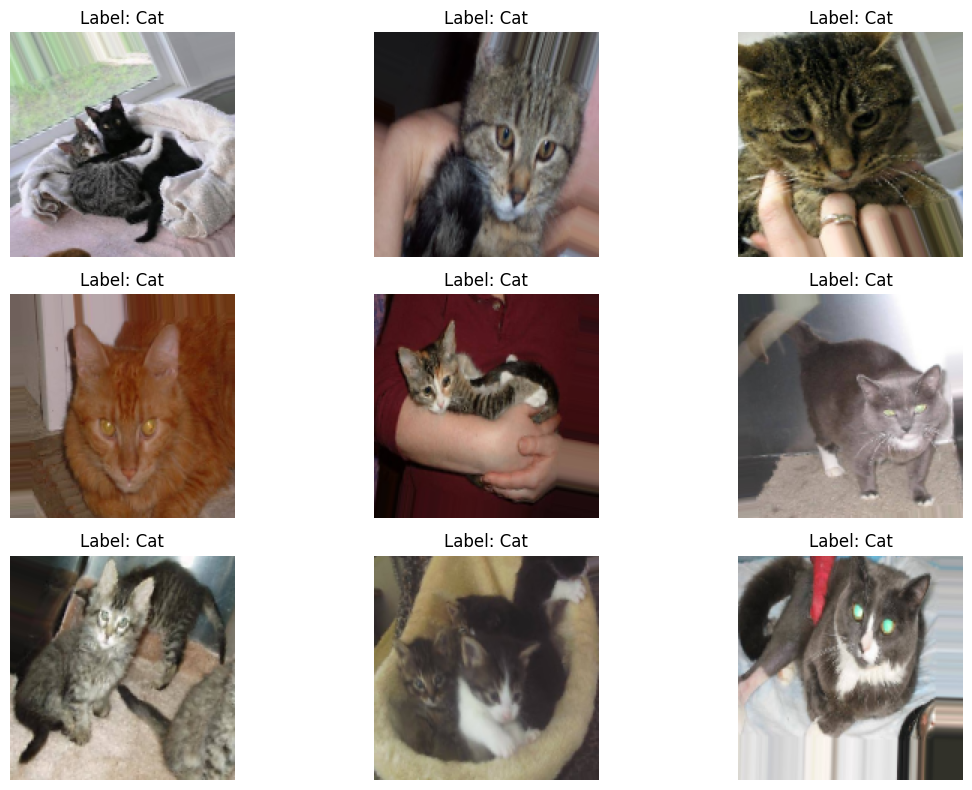

In [27]:
sample_images, sample_labels = next(train_generator)

# Plot sample images
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Reset generator
train_generator.reset()

In [28]:
custom_model = models.Sequential([
    # Input Layer
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # First Convolutional Block (32 filters)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    # Second Convolutional Block (64 filters)
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    # Third Convolutional Block (128 filters)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    
    # Output Layer
    layers.Dense(2, activation='softmax')
])

custom_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,329,346 (81.36 MB)

 Trainable params: 21,328,898 (81.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
custom_callbacks = [
    ModelCheckpoint(
        CUSTOM_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [31]:
print("Starting Custom CNN training...")
history_custom = custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=custom_callbacks,
    verbose=1
)

Starting Custom CNN training...
Epoch 1/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6066 - loss: 6.8280
Epoch 1: val_accuracy improved from None to 0.67633, saving model to custom_cnn_model.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - accuracy: 0.6450 - loss: 2.6562 - val_accuracy: 0.6763 - val_loss: 1.0196 - learning_rate: 0.0010
Epoch 2/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6878 - loss: 0.6144
Epoch 2: val_accuracy did not improve from 0.67633
384/384 ━━━━━━━━━━━━━━━━━━━━ 105s 273ms/step - accuracy: 0.6835 - loss: 0.6179 - val_accuracy: 0.4623 - val_loss: 1.4821 - learning_rate: 0.0010
Epoch 3/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6944 - loss: 0.6085
Epoch 3: val_accuracy did not improve from 0.67633
384/384 ━━━━━━━━━━━━━━━━━━━━ 105s 272ms/step - accuracy: 0.6978 - loss: 0.6003 - val_accuracy: 0.6590 - val_loss: 0.7531 - learning_rate: 0.0010
Epoch 4/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7045 - 

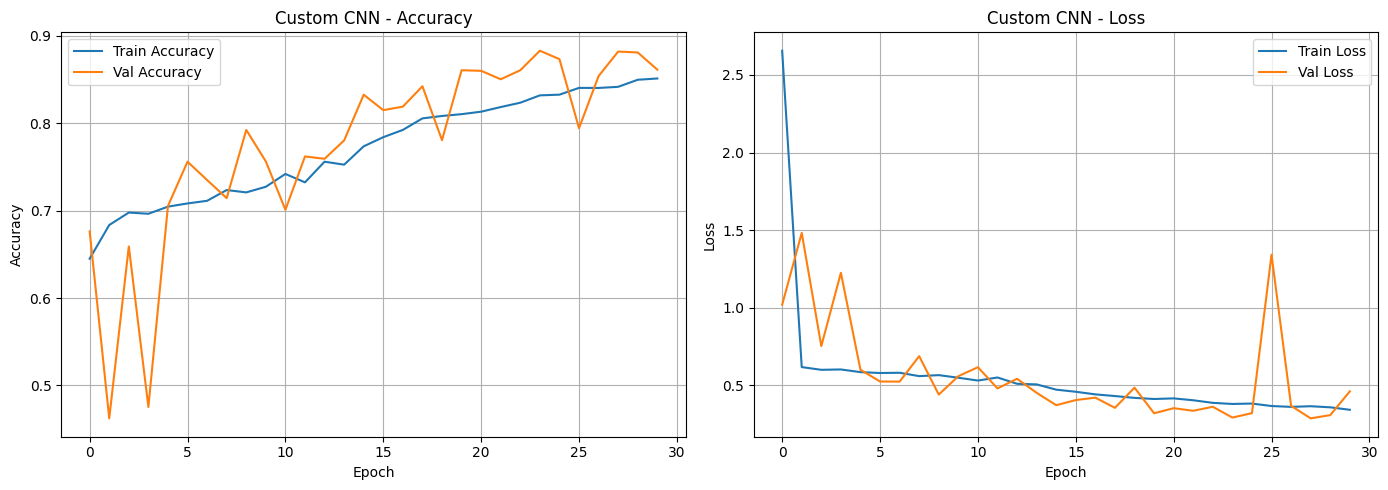

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_custom.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_custom.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Custom CNN - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_custom.history['loss'], label='Train Loss')
axes[1].plot(history_custom.history['val_loss'], label='Val Loss')
axes[1].set_title('Custom CNN - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('custom_cnn_history.png')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step

Custom CNN Classification Report:
              precision    recall  f1-score   support

         cat       0.90      0.92      0.91      2000
         dog       0.83      0.81      0.82      1000

    accuracy                           0.88      3000
   macro avg       0.87      0.86      0.87      3000
weighted avg       0.88      0.88      0.88      3000



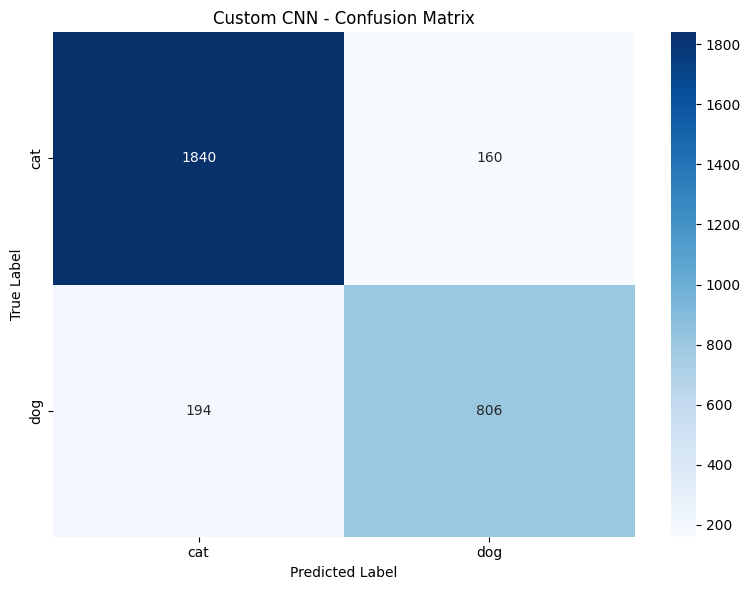


Custom CNN Validation Accuracy: 0.8820


In [33]:
val_generator.reset()

# Get predictions
predictions_custom = custom_model.predict(val_generator, verbose=1)
predicted_classes_custom = np.argmax(predictions_custom, axis=1)
true_classes = val_generator.classes

# Classification report
class_names = list(val_generator.class_indices.keys())
print("\nCustom CNN Classification Report:")
print(classification_report(true_classes, predicted_classes_custom, target_names=class_names))

# Confusion matrix
cm_custom = confusion_matrix(true_classes, predicted_classes_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Custom CNN - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('custom_cnn_confusion_matrix.png')
plt.show()

# Calculate accuracy
accuracy_custom = np.sum(predicted_classes_custom == true_classes) / len(true_classes)
print(f"\nCustom CNN Validation Accuracy: {accuracy_custom:.4f}")

In [73]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

print(f"Test samples: {test_generator.samples}")

# Make predictions
print(f"\nMaking predictions with {custom_model}...")
test_predictions = custom_model.predict(test_generator, verbose=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get filenames
filenames = test_generator.filenames
image_ids = [os.path.basename(f) for f in filenames]

# Create submission dataframe
# Label: 1 = dog, 0 = cat
submission = pd.DataFrame({
    'ID': image_ids,
    'label': test_predicted_classes
})

submission.to_csv('submission.csv', index=False)
print(f"\n✓ Predictions saved to submission.csv")
print("\nFirst 10 predictions:")
print(submission.head(10))

# Show prediction distribution
print("\nPrediction Distribution:")
print(submission['label'].value_counts())
plt.figure(figsize=(8, 6))
submission['label'].value_counts().plot(kind='bar', color=['#e74c3c', '#3498db'])
plt.title('Test Set Prediction Distribution')
plt.xlabel('Label (0=Cat, 1=Dog)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('prediction_distribution.png')
plt.show()

Found 0 images belonging to 0 classes.
Test samples: 0

Making predictions with <Sequential name=sequential_2, built=True>...


ValueError: The PyDataset has length 0

In [ ]:
# Reset test generator
test_generator.reset()

# Get some test images
num_display = 9
test_images = []
for i in range(num_display):
    img = next(test_generator)[0]
    test_images.append(img)

# Plot predictions
plt.figure(figsize=(12, 12))
for i in range(num_display):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    
    pred_label = 'Dog' if test_predicted_classes[i] == 1 else 'Cat'
    confidence = np.max(test_predictions[i]) * 100
    
    plt.title(f'Pred: {pred_label}\nConfidence: {confidence:.1f}%')
    plt.axis('off')

plt.tight_layout()
plt.savefig('test_predictions_visualization.png')
plt.show()

print("\n" + "="*60)
print("TRAINING AND PREDICTION COMPLETE!")
print("="*60)
print(f"✓ Custom CNN model saved: {CUSTOM_MODEL_PATH}")
print(f"✓ EfficientNet model saved: {EFFICIENTNET_MODEL_PATH}")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Submission file: submission.csv")
print("="*60)